# DandeLiion API - Example Notebook

In [1]:
import dandeliion.client as dandeliion
import numpy as np
import matplotlib.pyplot as plt

# Optional
import pybamm

# The following lines enable logging output in this notebook
import sys
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

In [2]:
print("DadneLiion Client version:", dandeliion.__version__)

DadneLiion Client version: 1.1


### Authentication
Define the simulator object by providing the API URL and API token:

In [ ]:
api_url = "https://api.dandeliion.com/v1"
api_key = "API KEY"  # Replace with your actual API key
simulator = dandeliion.Simulator(api_url, api_key)

### Battery parameters
Can be a valid BPX file name/path or already read-in valid BPX as a `dict` or `BPX` object itself:

In [5]:
params = 'AE_gen1_BPX.json'

### Experiment
PyBaMM or DandeLiion `Experiment` object, for example:

In [24]:
# Drive cycle data
import pandas as pd
drive_cycle_data = pd.read_csv("US06.csv", comment="#", header=None).to_numpy()
drive_cycle = np.column_stack([drive_cycle_data[:, 0], -drive_cycle_data[:, 1]])  # Negative current for discharge

# Use dandeliion.Experiment if PyBaMM is not installed
# experiment = dandeliion.Experiment(
experiment = pybamm.Experiment(
  [
    (
      "Discharge at 1C until 3.8 V",
      "Hold at 3.8 V for 10 minutes (5 second period)",
      "Rest for 300 seconds",
      "Charge at 2000 mA for 1 hour or until 4.0 V",
      "Rest for 5 min",
      "Discharge at 20W for 20 minutes or until 2.5V",
      "Rest for 300 s (1 second period)",
      "Charge at C/2 until 3.8 V (0.5 min period)",
      "Hold at 3.8V for 0.1 hr (1s period)",
    ),
    (
      pybamm.step.current(drive_cycle),
    ) * 2,
  ],
  period = "10 s",
)

### Additional model/backend-specific parameters
Define a dictionary of extra parameters outside the BPX standard, such as mesh, initial state of charge or voltage, etc.:

In [25]:
extra_params = {}

# Number of mesh points in PyBaMM format (default is 16 mesh points everywhere):
extra_params['Mesh'] = {"x_n": 16, "x_s": 16, "x_p": 16, "r_n": 16, "r_p": 16}

# Initial state of charge (default is 1):
extra_params['Initial SOC'] = 1.0

### Start the simulation in the cloud

In [26]:
solution = dandeliion.solve(
    simulator=simulator,
    params=params,
    experiment=experiment,      # optional (1C discharge for 1 hour or until the `Lower voltage cut-off [V]` from BPX will be used by default)
    extra_params=extra_params,  # optional (initial conditions from the BPX, fully charged state, and single cell Newman model with constant temperature will be used by default)
    is_blocking=True            # optional (`True` by default)
)

/home/schewtsj/Documents/dandeliion/dandeliion-client/.venv/lib/python3.12/site-packages/pydantic/_internal/_decorators_v1.py:171: UserWarning: The minimum voltage computed from the STO limits (2.4988861558265327 V) is less than the lower voltage cut-off (2.5 V) with the absolute tolerance v_tol = 0.001 V
  model_dict_new = validator(model_dict)


INFO:dandeliion.client.simulator:[running] | Your simulation is now running on AWS Lambda.
INFO:dandeliion.client.simulator:[running] | Your simulation is now running on AWS Lambda.
INFO:dandeliion.client.simulator:[success] | [2025-07-11 10:45:24.838] [info] Total time: 6.383 s


If solve is run in non-blocking mode, you can still force the program to wait for the simulation to finish by calling `join()` on the solution returned by it (when used for an already finished simulation, it simply returns instantly).

In [27]:
print("Status:", solution.status) 
solution.join()
print("Status:", solution.status) 

Status: success
Status: success


### Accessing the log file 

In [28]:
print(solution.log)

Your simulation is now running on AWS Lambda. 
[2025-07-11 10:45:18.455] [info] Starting dandeliion-models v0.2.0...
[2025-07-11 10:45:18.455] [info] Parsing input JSON file parameters.json...
[2025-07-11 10:45:18.464] [info] Input JSON file parsing time: 8.468 ms
[2025-07-11 10:45:18.464] [info] Initialising simulation parameters...
[2025-07-11 10:45:18.464] [info] Title: About:Energy Gen1 Demo 21700 NMC811|graphite 5 Ah cell
[2025-07-11 10:45:18.464] [info] Model: DFN
[2025-07-11 10:45:18.470] [info] Thermal model: Isothermal
[2025-07-11 10:45:18.470] [info] Found time series input...
[2025-07-11 10:45:18.470] [info] Time series input: Current [A]
[2025-07-11 10:45:18.470] [info] Found DandeLiion Experiment...
[2025-07-11 10:45:18.470] [info] Number of instructions to parse: 11
[2025-07-11 10:45:18.470] [info] Solver mode: Fast (default)
[2025-07-11 10:45:18.470] [info] Simulation parameters initialisation time: 6.223 ms
[2025-07-11 10:45:18.470] [info] Starting the simulation...
[20

### Results
Print all available keys in the solution object.
Here method `keys()` is used to get all available keys in the solution object.

In [29]:
for key in sorted(solution.keys()):
    print(key)

Current [A]
Electrolyte concentration [mol.m-3]
Electrolyte potential [V]
Electrolyte x-coordinate [m]
Temperature [K]
Time [s]
Voltage [V]
X-averaged negative electrode exchange current density [A.m-2]
X-averaged negative electrode potential [V]
X-averaged negative electrode surface concentration [mol.m-3]
X-averaged positive electrode exchange current density [A.m-2]
X-averaged positive electrode potential [V]
X-averaged positive electrode surface concentration [mol.m-3]


In [30]:
# Print the final values of time, voltage, and temperature
print(f"Final time [s]: {solution['Time [s]'][-1]}")
print(f"Final voltage [V]: {solution['Voltage [V]'][-1]}")
print(f"Final temperature [K]: {solution['Temperature [K]'][-1]}")

INFO:dandeliion.client.solution:Fetching 'Time [s]' column from simulator
Final time [s]: 6596.0361328125
INFO:dandeliion.client.solution:Fetching 'Voltage [V]' column from simulator
Final voltage [V]: 3.6802161457188616
INFO:dandeliion.client.solution:Fetching 'Temperature [K]' column from simulator
Final temperature [K]: 298.15


INFO:dandeliion.client.solution:Fetching 'Current [A]' column from simulator


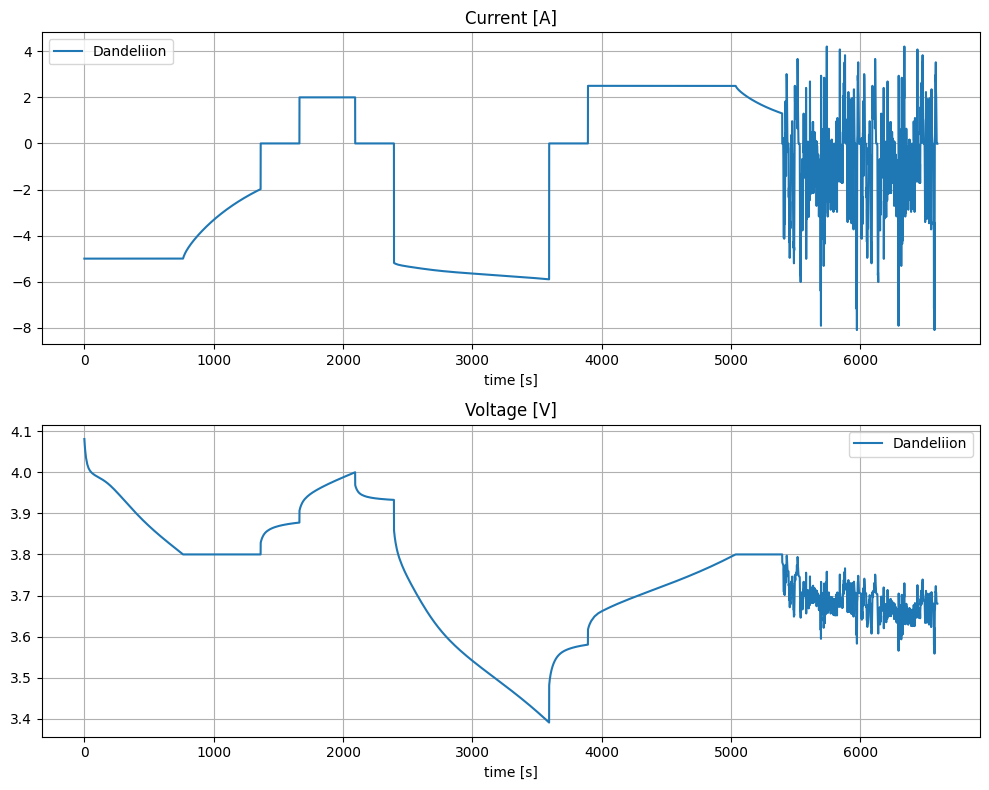

In [31]:
# Plot current and voltage vs time.
# Here we access scalar values vs time.
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
axs[0].plot(solution["Time [s]"], solution["Current [A]"], label="Dandeliion")
axs[0].set_xlabel("time [s]")
axs[0].set_title("Current [A]")
axs[0].legend()
axs[0].grid()
axs[1].plot(solution["Time [s]"], solution["Voltage [V]"], label="Dandeliion")
axs[1].set_xlabel("time [s]")
axs[1].set_title("Voltage [V]")
axs[1].legend()
axs[1].grid()
plt.tight_layout()
plt.show()

INFO:dandeliion.client.solution:Fetching 'Electrolyte x-coordinate [m]' column from simulator
INFO:dandeliion.client.solution:Fetching 'Electrolyte concentration [mol.m-3]' column from simulator


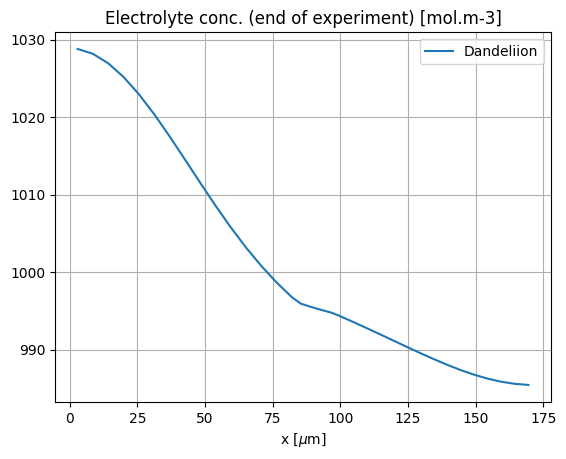

In [32]:
# Concentration in the electrolyte vs `x` at the last time step.
# Here we access spatially dependent values vs time.
plt.plot(
    solution["Electrolyte x-coordinate [m]"] * 1e6,
    solution["Electrolyte concentration [mol.m-3]"][-1],
    label="Dandeliion",
)
plt.xlabel(r"x [$\mu$m]")
plt.title("Electrolyte conc. (end of experiment) [mol.m-3]")
plt.legend()
plt.grid()
plt.show()

In [33]:
# A list of output times (optional)
t_eval = np.arange(0, 20, 1)

# If the user needs the solution at the `t_eval` times, the following code can be used (works only correctly on columns with timeline data).
# This is a linear interpolation with constant extrapolation:
print("Time [s]\tVoltage [V]")
for t, voltage in zip(t_eval, solution["Voltage [V]"](t=t_eval)):
    print(f"{t}\t{voltage}")


Time [s]	Voltage [V]
0	4.080929637658874
1	4.07556477797119
2	4.0706389644456165
3	4.065947609011764
4	4.06198428762323
5	4.058101858906398
6	4.0542194301895655
7	4.0511337764210245
8	4.0483895976303215
9	4.0456454188396185
10	4.042901240048916
11	4.040157061258213
12	4.03741288246751
13	4.034999605785829
14	4.033358434025193
15	4.031717262264559
16	4.030076090503924
17	4.028434918743289
18	4.026793746982654
19	4.02515257522202


### Storing and retrieving simulation and its solutions

You can export simulation output at any time. It will try to fetch whatever solutions & logs are available at that time and dump it into an output file. You can use that file externally or to create a new solution object. If the simulation was still running at the time of export, you can provide the API key used to start the simulation to reconnect that solution object to the original simulation to retrieve the latest updates.

In [34]:
solution_file = 'test_solution.json'

solution.dump(solution_file)
restored_solution = dandeliion.Simulator.restore(solution_file, api_key=api_key)